## Attribute Information:	
1. **loc             :** numeric % McCabe's line count of code
2. **v(g)            :** numeric % McCabe "cyclomatic complexity"
3. **ev(g)           :** numeric % McCabe "essential complexity"
4. **iv(g)           :** numeric % McCabe "design complexity"
5. **n               :** numeric % Halstead total operators + operands
6. **v               :** numeric % Halstead "volume"
7. **l               :** numeric % Halstead "program length"
8. **d               :** numeric % Halstead "difficulty"
9. **e               :** numeric % Halstead "effort"
11. **b               :** numeric % Halstead 
12. **t               :** numeric % Halstead's time estimator
13. **lOCode          :** numeric % Halstead's line count
14. **lOComment       :** numeric % Halstead's count of lines of comments
15. **lOBlank         :** numeric % Halstead's count of blank lines
16. **lOCodeAndComment :** numeric
17. **uniq_Op         :** numeric % unique operators
18. **uniq_Opnd       :** numeric % unique operands
19. **total_Op        :** numeric % total operators
20. **total_Opnd      :** numeric % total operands
21. **branchCount     :** numeric % of the flow graph
22. **defects         :** {false,true} % module has/has not one or more % reported defects

---

## Halstead groups/measures
- **Base measures:**
  - mu1             = number of unique operators
  - mu2             = number of unique operands
  - N1              = total occurrences of operators
  - N2              = total occurrences of operands
  - length     = N  = N1 + N2
  - vocabulary = mu = mu1 + mu2
  - Constants set for each function:
     - mu1' =  2 = potential operator count (just the function name and the "return" operator)
     - mu2'      = potential operand count. (the number of arguments to the module)
  
  **For example, the expression "return max(w+x,x+y)" has "N1=4"
  operators "return, max, +,+)", "N2=4" operands (w,x,x,y),
  "mu1=3" unique operators (return, max,+), and "mu2=3" unique
  operands (w,x,y).**</br></br>  
- **Derived measures:**
    - P = volume = V = N * log2(mu) (the number of mental comparisons needed to write a program of length N)
   - V* = volume on minimal implementation
         = (2 + mu2')*log2(2 + mu2')
   - L  = program length = V*/N
   - D  = difficulty = 1/L
   - L' = 1/D 
   - I  = intelligence = L'*V'
   - E  = effort to write program = V/L 
   - T  = time to write program = E/18 seconds

In [21]:
# Imports
import numpy as np
import pandas as pd
import os
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings

warnings.filterwarnings("ignore")

In [22]:
# read data
df = pd.read_csv("../data/raw/jm1.csv")
df

loc  v(g)  ev(g)  iv(g)      n        v     l      d       i  \
0        1.1   1.4    1.4    1.4    1.3     1.30  1.30   1.30    1.30   
1        1.0   1.0    1.0    1.0    1.0     1.00  1.00   1.00    1.00   
2       72.0   7.0    1.0    6.0  198.0  1134.13  0.05  20.31   55.85   
3      190.0   3.0    1.0    3.0  600.0  4348.76  0.06  17.06  254.87   
4       37.0   4.0    1.0    4.0  126.0   599.12  0.06  17.19   34.86   
...      ...   ...    ...    ...    ...      ...   ...    ...     ...   
10880   18.0   4.0    1.0    4.0   52.0   241.48  0.14   7.33   32.93   
10881    9.0   2.0    1.0    2.0   30.0   129.66  0.12   8.25   15.72   
10882   42.0   4.0    1.0    2.0  103.0   519.57  0.04  26.40   19.68   
10883   10.0   1.0    1.0    1.0   36.0   147.15  0.12   8.44   17.44   
10884   19.0   3.0    1.0    1.0   58.0   272.63  0.09  11.57   23.56   

              e  ...  lOCode  lOComment  lOBlank  locCodeAndComment  uniq_Op  \
0          1.30  ...       2          2        2                  2      1.2   
1          1.00  ...       1          1        1                  1        1   
2      23029.10  ...      51         10        8                  1       17   
3      74202.67  ...     129         29       28                  2       17   
4      10297.30  ...      28          1        6                  0       11   
...         ...  ...     ...        ...      ...                ...      ...   
10880   1770.86  ...      13          0        2                  0       10   
10881   1069.68  ...       5          0        2                  0       12   
10882  13716.72  ...      29          1       10                  0       18   
10883   1241.57  ...       6          0        2                  0        9   
10884   3154.67  ...      13          0        2                  1       12   

       uniq_Opnd total_Op total_Opnd branchCount defects  
0            1.2      1.2        1.2         1.4   False  
1              1        1          1           1    True  
2             36      112         86          13    True  
3            135      329        271           5    True  
4             16       76         50           7    True  
...          ...      ...        ...         ...     ...  
10880         15       30         22           7   False  
10881          8       19         11           3   False  
10882         15       59         44           7   False  
10883          8       21         15           1   False  
10884         14       31         27           5   False  

[10885 rows x 22 columns]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10885 entries, 0 to 10884
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                10885 non-null  float64
 1   v(g)               10885 non-null  float64
 2   ev(g)              10885 non-null  float64
 3   iv(g)              10885 non-null  float64
 4   n                  10885 non-null  float64
 5   v                  10885 non-null  float64
 6   l                  10885 non-null  float64
 7   d                  10885 non-null  float64
 8   i                  10885 non-null  float64
 9   e                  10885 non-null  float64
 10  b                  10885 non-null  float64
 11  t                  10885 non-null  float64
 12  lOCode             10885 non-null  int64  
 13  lOComment          10885 non-null  int64  
 14  lOBlank            10885 non-null  int64  
 15  locCodeAndComment  10885 non-null  int64  
 16  uniq_Op            108

In [24]:
# replace '?' with np.nan as they show the same meaning of not knowing the data value.
df = df.applymap(lambda x: np.nan if x == "?" else x)
for col in df.columns[16:-1]:
    df[col] = df[col].astype(float)

df["defects"] = df["defects"].astype(int)

In [25]:
df.describe().T

count          mean            std  min     25%      50%  \
loc                10885.0     42.016178      76.593332  1.0   11.00    23.00   
v(g)               10885.0      6.348590      13.019695  1.0    2.00     3.00   
ev(g)              10885.0      3.401047       6.771869  1.0    1.00     1.00   
iv(g)              10885.0      4.001599       9.116889  1.0    1.00     2.00   
n                  10885.0    114.389738     249.502091  0.0   14.00    49.00   
v                  10885.0    673.758017    1938.856196  0.0   48.43   217.13   
l                  10885.0      0.135335       0.160538  0.0    0.03     0.08   
d                  10885.0     14.177237      18.709900  0.0    3.00     9.09   
i                  10885.0     29.439544      34.418313  0.0   11.86    21.93   
e                  10885.0  36836.365343  434367.801255  0.0  161.94  2031.02   
b                  10885.0      0.224766       0.646408  0.0    0.02     0.07   
t                  10885.0   2046.464876   24131.544463  0.0    9.00   112.83   
lOCode             10885.0     26.252274      59.611201  0.0    4.00    13.00   
lOComment          10885.0      2.737529       9.008608  0.0    0.00     0.00   
lOBlank            10885.0      4.625540       9.968130  0.0    0.00     2.00   
locCodeAndComment  10885.0      0.370785       1.907969  0.0    0.00     0.00   
uniq_Op            10880.0     11.177592      10.045255  0.0    5.00    11.00   
uniq_Opnd          10880.0     16.751857      26.667883  0.0    4.00    11.00   
total_Op           10880.0     68.110588     151.513836  0.0    8.00    29.00   
total_Opnd         10880.0     46.388989     100.351845  0.0    6.00    19.00   
branchCount        10880.0     11.292316      22.597617  1.0    3.00     5.00   
defects            10885.0      0.193477       0.395042  0.0    0.00     0.00   

                        75%          max  
loc                   46.00      3442.00  
v(g)                   7.00       470.00  
ev(g)                  3.00       165.00  
iv(g)                  4.00       402.00  
n                    119.00      8441.00  
v                    621.48     80843.08  
l                      0.16         1.30  
d                     18.90       418.20  
i                     36.78       569.78  
e                  11416.43  31079782.27  
b                      0.21        26.95  
t                    634.25   1726654.57  
lOCode                28.00      2824.00  
lOComment              2.00       344.00  
lOBlank                5.00       447.00  
locCodeAndComment      0.00       108.00  
uniq_Op               16.00       411.00  
uniq_Opnd             21.00      1026.00  
total_Op              71.00      5420.00  
total_Opnd            48.00      3021.00  
branchCount           13.00       826.00  
defects                0.00         1.00

## Feature Engineering

In [26]:
# feature creations
df["complex_by_line"] = (df["v(g)"] + df["ev(g)"] + df["iv(g)"]) / df["loc"]
df["code_by_cmtblank"] = df["lOCode"] / (df["lOComment"] + df["lOBlank"])
df["lines"] = (df["loc"] + df["lOCode"]) / 2
df["Opratio"] = df["uniq_Op"] / df["total_Op"]
df["Opndratio"] = df["uniq_Opnd"] / df["total_Opnd"]

# drop some features (feature selection)
df.drop(["n", "locCodeAndComment"], axis=1, inplace=True)

# fill null values with 0
df.fillna(0, inplace=True)
df = df.replace(np.inf, 0)

# save processed data
os.makedirs("../data/processed", exist_ok=True)
df.to_csv("../data/processed/processed_data.csv")

In [27]:
df.describe().T

count          mean            std      min         25%  \
loc               10885.0     42.016178      76.593332  1.00000   11.000000   
v(g)              10885.0      6.348590      13.019695  1.00000    2.000000   
ev(g)             10885.0      3.401047       6.771869  1.00000    1.000000   
iv(g)             10885.0      4.001599       9.116889  1.00000    1.000000   
v                 10885.0    673.758017    1938.856196  0.00000   48.430000   
l                 10885.0      0.135335       0.160538  0.00000    0.030000   
d                 10885.0     14.177237      18.709900  0.00000    3.000000   
i                 10885.0     29.439544      34.418313  0.00000   11.860000   
e                 10885.0  36836.365343  434367.801255  0.00000  161.940000   
b                 10885.0      0.224766       0.646408  0.00000    0.020000   
t                 10885.0   2046.464876   24131.544463  0.00000    9.000000   
lOCode            10885.0     26.252274      59.611201  0.00000    4.000000   
lOComment         10885.0      2.737529       9.008608  0.00000    0.000000   
lOBlank           10885.0      4.625540       9.968130  0.00000    0.000000   
uniq_Op           10885.0     11.172458      10.045803  0.00000    5.000000   
uniq_Opnd         10885.0     16.744162      26.664174  0.00000    4.000000   
total_Op          10885.0     68.079302     151.486061  0.00000    8.000000   
total_Opnd        10885.0     46.367680     100.333717  0.00000    6.000000   
branchCount       10885.0     11.287129      22.593722  0.00000    3.000000   
defects           10885.0      0.193477       0.395042  0.00000    0.000000   
complex_by_line   10885.0      0.426560       0.286643  0.01049    0.250000   
code_by_cmtblank  10885.0      3.965634       5.466795  0.00000    0.000000   
lines             10885.0     34.134226      66.780718  0.50000    8.500000   
Opratio           10885.0      0.352603       0.285011  0.00000    0.136054   
Opndratio         10885.0      0.509340       0.301759  0.00000    0.315789   

                          50%           75%          max  
loc                 23.000000     46.000000      3442.00  
v(g)                 3.000000      7.000000       470.00  
ev(g)                1.000000      3.000000       165.00  
iv(g)                2.000000      4.000000       402.00  
v                  217.130000    621.480000     80843.08  
l                    0.080000      0.160000         1.30  
d                    9.090000     18.900000       418.20  
i                   21.930000     36.780000       569.78  
e                 2031.020000  11416.430000  31079782.27  
b                    0.070000      0.210000        26.95  
t                  112.830000    634.250000   1726654.57  
lOCode              13.000000     28.000000      2824.00  
lOComment            0.000000      2.000000       344.00  
lOBlank              2.000000      5.000000       447.00  
uniq_Op             11.000000     16.000000       411.00  
uniq_Opnd           11.000000     21.000000      1026.00  
total_Op            29.000000     71.000000      5420.00  
total_Opnd          19.000000     48.000000      3021.00  
branchCount          5.000000     13.000000       826.00  
defects              0.000000      0.000000         1.00  
complex_by_line      0.364865      0.560440         5.00  
code_by_cmtblank     2.750000      5.000000       118.00  
lines               18.000000     37.000000      3133.00  
Opratio              0.290323      0.500000         1.00  
Opndratio            0.500000      0.722222         1.00

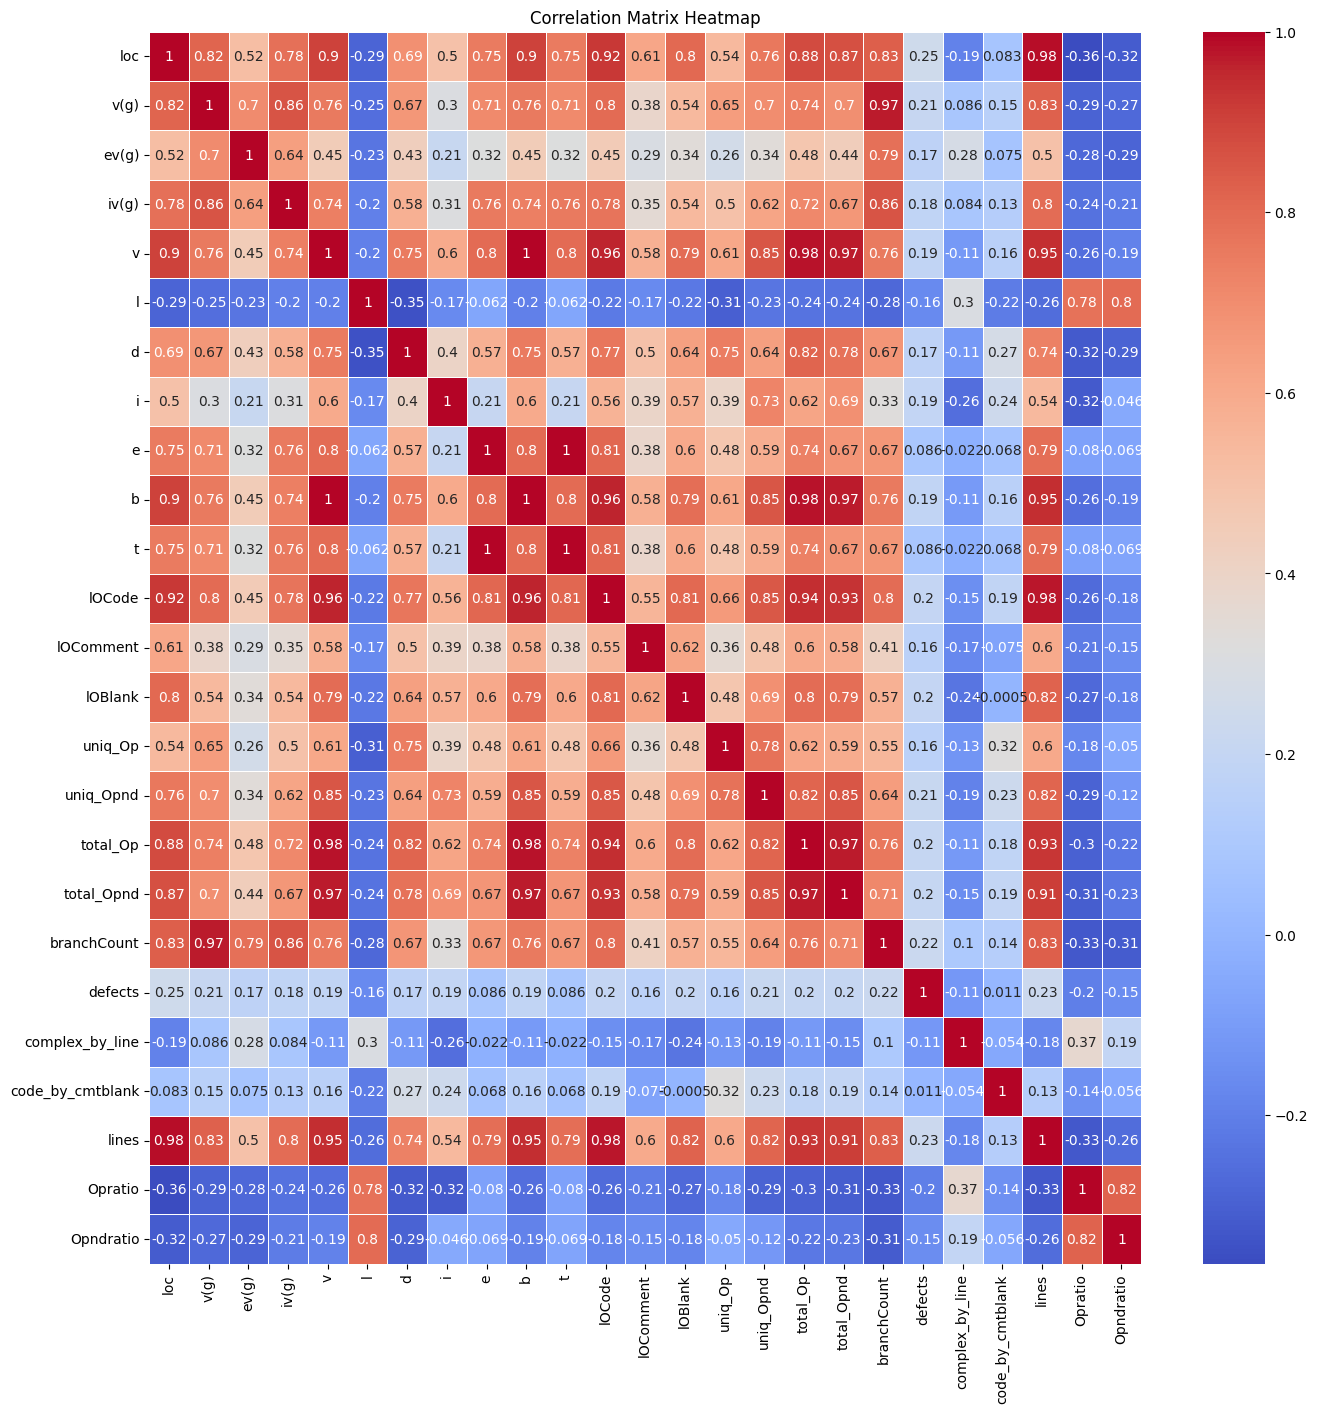

In [28]:
# correlation plot
corr_matrix = df.corr()

plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

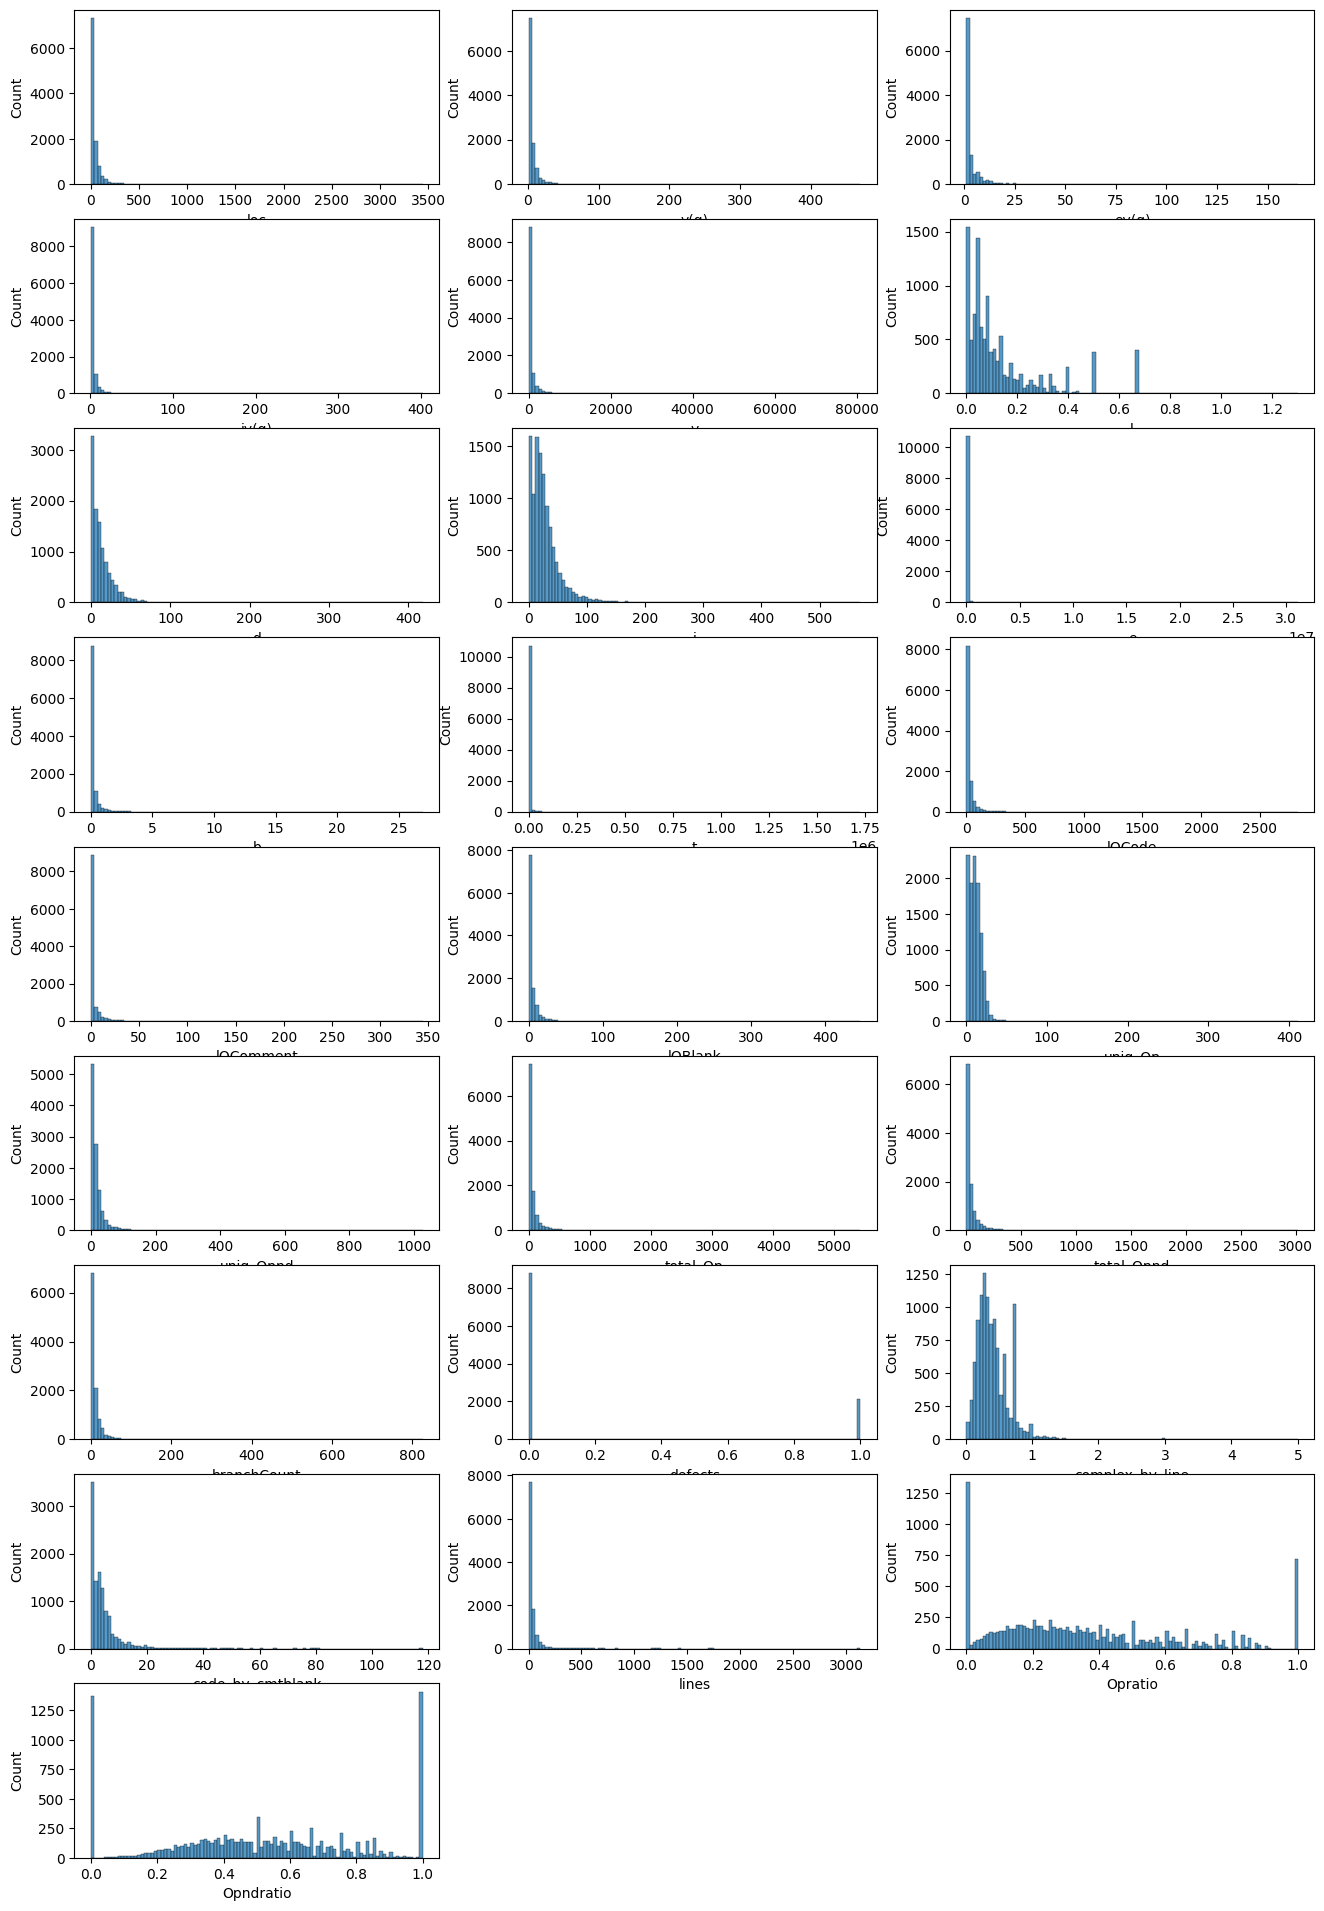

In [29]:
# histogram distribution of features
i = 1
plt.figure(figsize=(16, 24))
for c in df.columns:
    plt.subplot(df.drop(["defects"], axis=1).shape[1] // 3 + 1, 3, i)
    sns.histplot(x=df[c], bins=100)
    plt.xlabel = c
    i += 1

- All feature distributions are skewed, also showing exponential distribution fashion.
- Need to normalize them.
- Transformation techniques like log transform, box-cox transform, etc. will help.

## Define scaling and transformation

In [30]:
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    """Box-cox transformer custom sklearn transform."""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in X.columns:
            X[column] = boxcox(X[column] + 1)[0]
        return X

In [31]:
boxcox_transformer = BoxCoxTransformer()
std_scaler = StandardScaler()

In [32]:
# define model artifacts
artifacts = {}

## Logistic Regression

In [33]:
import optuna
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score


# Define an objective function to optimize
def objective(trial):
    # Load the Iris dataset
    X, y = df.drop(["defects"], axis=1), df["defects"]
    X = pd.concat([boxcox_transformer.transform(X.iloc[:, :-2]), X.iloc[:, -2:]], axis=1)
    X_ss = std_scaler.fit_transform(X)
    X = pd.DataFrame(X_ss, columns=X.columns)
    # Define hyperparameters to optimize
    C = trial.suggest_float("C", 0.7, 1)
    solver = trial.suggest_categorical("solver", ["liblinear", "newton-cholesky", "saga"])
    max_iter = trial.suggest_int("max_iter", 50, 150, step=50)

    # Create a logistic regression with suggested hyperparameters
    model = LogisticRegression(C=C, solver=solver, max_iter=max_iter)

    # Perform stratified k-fold cross-validation with train-test splits
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Adjust n_splits and other parameters as needed
    scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)

    # Calculate the mean accuracy
    mean_roc_auc_score = np.mean(scores)

    return mean_roc_auc_score


# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=25)

# Print the best hyperparameters and their corresponding loss (1 - accuracy)
best_params = study.best_params
best_roc_auc_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_roc_auc_score)

logreg_artifacts = {"hyperparameters": best_params, "roc_auc_score": best_roc_auc_score}

artifacts["LogisticRegression"] = logreg_artifacts

[I 2023-10-24 09:26:15,057] A new study created in memory with name: no-name-a2606e99-f92e-4c0f-bf6e-e202559e9686


[I 2023-10-24 09:26:16,095] Trial 0 finished with value: 0.7234321867643514 and parameters: {'C': 0.8214488460441713, 'solver': 'liblinear', 'max_iter': 50}. Best is trial 0 with value: 0.7234321867643514.
[I 2023-10-24 09:26:17,068] Trial 1 finished with value: 0.7234388405015477 and parameters: {'C': 0.9899956651873661, 'solver': 'liblinear', 'max_iter': 100}. Best is trial 1 with value: 0.7234388405015477.
[I 2023-10-24 09:26:17,897] Trial 2 finished with value: 0.7234336475138985 and parameters: {'C': 0.9566789599664314, 'solver': 'newton-cholesky', 'max_iter': 50}. Best is trial 1 with value: 0.7234388405015477.
[I 2023-10-24 09:26:18,679] Trial 3 finished with value: 0.7234368935192784 and parameters: {'C': 0.9945729928927237, 'solver': 'newton-cholesky', 'max_iter': 150}. Best is trial 1 with value: 0.7234388405015477.
[I 2023-10-24 09:26:20,596] Trial 4 finished with value: 0.7231668475165199 and parameters: {'C': 0.7382617198052083, 'solver': 'saga', 'max_iter': 50}. Best is t

Best Hyperparameters: {'C': 0.9935958142541409, 'solver': 'liblinear', 'max_iter': 100}
Best Accuracy: 0.723442572850535


## KNeighborsClassifier

In [34]:
import optuna
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score


# Define an objective function to optimize
def objective(trial):
    # Load the Iris dataset
    X, y = df.drop(["defects"], axis=1), df["defects"]
    X = pd.concat([boxcox_transformer.transform(X.iloc[:, :-2]), X.iloc[:, -2:]], axis=1)
    X_ss = std_scaler.fit_transform(X)
    X = pd.DataFrame(X_ss, columns=X.columns)
    # Define hyperparameters to optimize
    n_neighbors = trial.suggest_int("n_neighbors", 50, 500, 50)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])

    # Create a knn classifier with suggested hyperparameters
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

    # Perform stratified k-fold cross-validation with train-test splits
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Adjust n_splits and other parameters as needed
    scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)

    # Calculate the mean accuracy
    mean_roc_auc_score = np.mean(scores)

    return mean_roc_auc_score


# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=25)

# Print the best hyperparameters and their corresponding loss (1 - accuracy)
best_params = study.best_params
best_roc_auc_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_roc_auc_score)

knn_artifacts = {"hyperparameters": best_params, "roc_auc_score": best_roc_auc_score}

artifacts["KNeighborsClassifier"] = knn_artifacts

[I 2023-10-24 09:26:47,080] A new study created in memory with name: no-name-d4994c8f-10f8-481d-9f26-564f0b482906
[I 2023-10-24 09:26:50,101] Trial 0 finished with value: 0.7513497572536526 and parameters: {'n_neighbors': 250, 'weights': 'distance'}. Best is trial 0 with value: 0.7513497572536526.
[I 2023-10-24 09:26:52,621] Trial 1 finished with value: 0.7209559533446633 and parameters: {'n_neighbors': 200, 'weights': 'uniform'}. Best is trial 0 with value: 0.7513497572536526.
[I 2023-10-24 09:26:54,188] Trial 2 finished with value: 0.7471365962628497 and parameters: {'n_neighbors': 50, 'weights': 'distance'}. Best is trial 0 with value: 0.7513497572536526.
[I 2023-10-24 09:26:55,734] Trial 3 finished with value: 0.7471365962628497 and parameters: {'n_neighbors': 50, 'weights': 'distance'}. Best is trial 0 with value: 0.7513497572536526.
[I 2023-10-24 09:27:00,562] Trial 4 finished with value: 0.7483127458972435 and parameters: {'n_neighbors': 450, 'weights': 'distance'}. Best is tria

Best Hyperparameters: {'n_neighbors': 250, 'weights': 'distance'}
Best Accuracy: 0.7513497572536526


## RandomForestClassifier

In [35]:
import optuna
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score


# Define an objective function to optimize
def objective(trial):
    # Load the Iris dataset
    X, y = df.drop(["defects"], axis=1), df["defects"]
    X = pd.concat([boxcox_transformer.transform(X.iloc[:, :-2]), X.iloc[:, -2:]], axis=1)
    X_ss = std_scaler.fit_transform(X)
    X = pd.DataFrame(X_ss, columns=X.columns)
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 50, 500, step=50)
    max_depth = trial.suggest_int("max_depth", 2, 8, step=2)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)

    # Create a random forest classifier with suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42
    )

    # Perform stratified k-fold cross-validation with train-test splits
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Adjust n_splits and other parameters as needed
    scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)

    # Calculate the mean accuracy
    mean_roc_auc_score = np.mean(scores)

    return mean_roc_auc_score


# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and their corresponding loss (1 - accuracy)
best_params = study.best_params
best_roc_auc_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_roc_auc_score)

rf_artifacts = {"hyperparameters": best_params, "roc_auc_score": best_roc_auc_score}

artifacts["RandomForestClassifier"] = rf_artifacts

[I 2023-10-24 09:28:07,131] A new study created in memory with name: no-name-b4ac1dc1-9373-4584-a728-0f183ed1f354
[I 2023-10-24 09:28:15,648] Trial 0 finished with value: 0.7239285398633633 and parameters: {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7239285398633633.
[I 2023-10-24 09:28:38,733] Trial 1 finished with value: 0.7238805742805107 and parameters: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7239285398633633.
[I 2023-10-24 09:28:54,269] Trial 2 finished with value: 0.7242251936627951 and parameters: {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7242251936627951.
[I 2023-10-24 09:29:49,582] Trial 3 finished with value: 0.7428724361403471 and parameters: {'n_estimators': 400, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.

Best Hyperparameters: {'n_estimators': 200, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 4}
Best Accuracy: 0.7442251747157974


## LGBMClassifier

In [36]:
# Define an objective function to optimize
def objective(trial):
    # Load the Iris dataset
    X, y = df.drop(["defects"], axis=1), df["defects"]
    X = pd.concat([boxcox_transformer.transform(X.iloc[:, :-2]), X.iloc[:, -2:]], axis=1)
    X_ss = std_scaler.fit_transform(X)
    X = pd.DataFrame(X_ss, columns=X.columns)
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 50, 500, step=50)
    max_depth = trial.suggest_int("max_depth", 2, 8, step=2)
    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    alpha = trial.suggest_float("reg_alpha", 0.0, 0.3)
    _lambda = trial.suggest_float("reg_lambda", 0.0, 0.2)

    # Create a lightgbm classifier with suggested hyperparameters
    model = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        reg_alpha=alpha,
        reg_lambda=_lambda,
        random_state=42,
        num_leaves=2**max_depth,
    )

    # Perform stratified k-fold cross-validation with train-test splits
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Adjust n_splits and other parameters as needed
    scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)

    # Calculate the mean accuracy
    mean_roc_auc_score = np.mean(scores)

    return mean_roc_auc_score


# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and their corresponding loss (1 - accuracy)
best_params = study.best_params
best_roc_auc_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_roc_auc_score)

lgb_artifacts = {"hyperparameters": best_params, "roc_auc_score": best_roc_auc_score}

artifacts["LGBMClassifier"] = lgb_artifacts

[I 2023-10-24 09:55:26,943] A new study created in memory with name: no-name-c7cedb96-0a2d-4d5f-a0fc-d2d73427a643


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:55:31,408] Trial 0 finished with value: 0.7303188955223252 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.08227599901554, 'reg_alpha': 0.061995866400556265, 'reg_lambda': 0.041254945611121}. Best is trial 0 with value: 0.7303188955223252.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:55:33,771] Trial 1 finished with value: 0.7251711135725065 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.0025343379073733247, 'reg_alpha': 0.1392359957618998, 'reg_lambda': 0.1358943685435387}. Best is trial 0 with value: 0.7303188955223252.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:55:38,597] Trial 2 finished with value: 0.7424846766052959 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.02919459669815862, 'reg_alpha': 0.205006048352196, 'reg_lambda': 0.01069747764849549}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:55:51,873] Trial 3 finished with value: 0.7302224822821026 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.002482833257830843, 'reg_alpha': 0.11322177629603718, 'reg_lambda': 0.024040359481188767}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Info] Number of positive: 1404, number of negative: 5853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4368
[LightGBM] [Info] Number of data points in the train set: 7257, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193468 -> initscore=-1.427629
[LightGBM] [Info] Start training from score -1.427629
[LightGBM] [Info] 

[I 2023-10-24 09:55:54,677] Trial 4 finished with value: 0.7164660432144353 and parameters: {'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.002026322567922807, 'reg_alpha': 0.1400955637066577, 'reg_lambda': 0.08945541021351838}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:55:59,661] Trial 5 finished with value: 0.7215576082342846 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.001763928609977787, 'reg_alpha': 0.14078668197634564, 'reg_lambda': 0.19785227706490893}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:56:04,551] Trial 6 finished with value: 0.7389405660186174 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.016535705896545475, 'reg_alpha': 0.09553075184076025, 'reg_lambda': 0.084926887261388}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:56:07,322] Trial 7 finished with value: 0.7282256792330877 and parameters: {'n_estimators': 350, 'max_depth': 2, 'learning_rate': 0.015065991108343323, 'reg_alpha': 0.25663029265431553, 'reg_lambda': 0.05579718479201881}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2023-10-24 09:56:13,268] Trial 8 finished with value: 0.741837729054447 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.02635711051491456, 'reg_alpha': 0.24297493621154445, 'reg_lambda': 0.18271907500830195}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:56:16,309] Trial 9 finished with value: 0.7407152066756536 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.029130741056876887, 'reg_alpha': 0.21240701319143576, 'reg_lambda': 0.06861695386553546}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-10-24 09:56:23,136] Trial 10 finished with value: 0.736280245500212 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.006538835254648644, 'reg_alpha': 0.008427578443718997, 'reg_lambda': 0.0004907107914235761}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:56:31,356] Trial 11 finished with value: 0.7324963522959794 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.047622676239233885, 'reg_alpha': 0.21809747476883096, 'reg_lambda': 0.1284877455389054}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:56:34,827] Trial 12 finished with value: 0.7393048642703999 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.02772628438698958, 'reg_alpha': 0.2956036972423898, 'reg_lambda': 0.19582556201556486}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:56:38,540] Trial 13 finished with value: 0.7339537717589314 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.08319387112103198, 'reg_alpha': 0.19584019550438136, 'reg_lambda': 0.0032666987999495104}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-10-24 09:56:43,188] Trial 14 finished with value: 0.7370834215651674 and parameters: {'n_estimators': 450, 'max_depth': 4, 'learning_rate': 0.00866158374087164, 'reg_alpha': 0.18416820121090313, 'reg_lambda': 0.12419967612348037}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2023-10-24 09:56:48,621] Trial 15 finished with value: 0.737984881840635 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.03960870855960541, 'reg_alpha': 0.255945788317534, 'reg_lambda': 0.1669265924193742}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:56:52,153] Trial 16 finished with value: 0.7410803102607776 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.01613233987345145, 'reg_alpha': 0.1775988690271222, 'reg_lambda': 0.10655000438425692}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:57:03,257] Trial 17 finished with value: 0.740505978933445 and parameters: {'n_estimators': 350, 'max_depth': 8, 'learning_rate': 0.005662147423199421, 'reg_alpha': 0.23857191741280215, 'reg_lambda': 0.16539125225735815}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:57:06,937] Trial 18 finished with value: 0.7377633753084037 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05310069487236371, 'reg_alpha': 0.297399845788377, 'reg_lambda': 0.0677431225459586}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:57:08,607] Trial 19 finished with value: 0.7329688177848679 and parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.024465260913395133, 'reg_alpha': 0.17368552706980955, 'reg_lambda': 0.027603091072557207}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193468 -> initscore=-1.427629
[LightGBM] [Info] Start training from score -1.427629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2023-10-24 09:57:20,596] Trial 20 finished with value: 0.7243096756280125 and parameters: {'n_estimators': 350, 'max_depth': 8, 'learning_rate': 0.0011451497393009684, 'reg_alpha': 0.23278119194465713, 'reg_lambda': 0.10433009009328459}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:57:25,516] Trial 21 finished with value: 0.7402761599284894 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.013850759546330768, 'reg_alpha': 0.17596673814273817, 'reg_lambda': 0.10881535151941671}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:57:28,850] Trial 22 finished with value: 0.7405248696014044 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.019130490828140462, 'reg_alpha': 0.20080155888915818, 'reg_lambda': 0.08546117200123311}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002536 seconds.
Yo

[I 2023-10-24 09:57:39,833] Trial 23 finished with value: 0.7418874363705908 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.010973587592221456, 'reg_alpha': 0.16553149715481147, 'reg_lambda': 0.14570340152189018}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:57:45,592] Trial 24 finished with value: 0.7375270401196593 and parameters: {'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.010437262046437128, 'reg_alpha': 0.21784436909803612, 'reg_lambda': 0.1522453607726446}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:57:53,914] Trial 25 finished with value: 0.7343290467005547 and parameters: {'n_estimators': 450, 'max_depth': 6, 'learning_rate': 0.035417501144712434, 'reg_alpha': 0.15985738262972188, 'reg_lambda': 0.18050000416893663}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:58:06,351] Trial 26 finished with value: 0.7385808753070006 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.022858396439529412, 'reg_alpha': 0.25681925949400036, 'reg_lambda': 0.1475462939808431}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:58:12,467] Trial 27 finished with value: 0.7335787857016406 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.051941633380022015, 'reg_alpha': 0.19806342744298186, 'reg_lambda': 0.17202055979358272}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:58:19,026] Trial 28 finished with value: 0.7347815907025684 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.03258851916774064, 'reg_alpha': 0.16059210115703518, 'reg_lambda': 0.14416959802408832}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:58:24,269] Trial 29 finished with value: 0.738792128843316 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.06580626507646882, 'reg_alpha': 0.2333709604151153, 'reg_lambda': 0.12200500152231279}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:58:37,751] Trial 30 finished with value: 0.7362790384843082 and parameters: {'n_estimators': 450, 'max_depth': 8, 'learning_rate': 0.021561290953301032, 'reg_alpha': 0.12074595199202962, 'reg_lambda': 0.1537555106304718}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:58:44,701] Trial 31 finished with value: 0.7399402919035619 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.012498721309789438, 'reg_alpha': 0.18179656809123657, 'reg_lambda': 0.1118943699417776}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:58:52,213] Trial 32 finished with value: 0.7409756463941936 and parameters: {'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.019516004986765947, 'reg_alpha': 0.16784369034070146, 'reg_lambda': 0.1355291078175419}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2023-10-24 09:58:55,025] Trial 33 finished with value: 0.728958065136207 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.011011124506322818, 'reg_alpha': 0.15126197139157663, 'reg_lambda': 0.10075451535689231}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2023-10-24 09:59:02,812] Trial 34 finished with value: 0.7415073822935594 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01690292415286733, 'reg_alpha': 0.18817722595793115, 'reg_lambda': 0.04580427587389085}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:59:05,665] Trial 35 finished with value: 0.730381214229415 and parameters: {'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.027119429733767988, 'reg_alpha': 0.1941772565888059, 'reg_lambda': 0.038703270940750205}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:59:14,810] Trial 36 finished with value: 0.7355698782051433 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.03797863858617983, 'reg_alpha': 0.13121644228933976, 'reg_lambda': 0.024058924918787417}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:59:19,666] Trial 37 finished with value: 0.7262671157818575 and parameters: {'n_estimators': 350, 'max_depth': 4, 'learning_rate': 0.09586846900557687, 'reg_alpha': 0.15017903726002055, 'reg_lambda': 0.010111225912203758}. Best is trial 2 with value: 0.7424846766052959.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-10-24 09:59:25,987] Trial 38 finished with value: 0.7424942332959943 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.017185744934594342, 'reg_alpha': 0.11088637773731931, 'reg_lambda': 0.04255690009953687}. Best is trial 38 with value: 0.7424942332959943.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:59:36,089] Trial 39 finished with value: 0.7409976868189577 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.008518607193922114, 'reg_alpha': 0.11063257281380073, 'reg_lambda': 0.021708264835833276}. Best is trial 38 with value: 0.7424942332959943.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:59:44,278] Trial 40 finished with value: 0.7412335096891765 and parameters: {'n_estimators': 450, 'max_depth': 6, 'learning_rate': 0.01351417051450556, 'reg_alpha': 0.08652631680588449, 'reg_lambda': 0.015247023220747346}. Best is trial 38 with value: 0.7424942332959943.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:59:49,365] Trial 41 finished with value: 0.7426055060743293 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01823127627614421, 'reg_alpha': 0.13985321371277454, 'reg_lambda': 0.04129285563167279}. Best is trial 41 with value: 0.7426055060743293.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 09:59:55,220] Trial 42 finished with value: 0.7407818718985473 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.02116111559929703, 'reg_alpha': 0.14539994332246428, 'reg_lambda': 0.033506328090834626}. Best is trial 41 with value: 0.7426055060743293.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 10:00:00,198] Trial 43 finished with value: 0.7399474091142405 and parameters: {'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.02685402489319216, 'reg_alpha': 0.13183904016674833, 'reg_lambda': 0.04561610372436382}. Best is trial 41 with value: 0.7426055060743293.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 10:00:03,963] Trial 44 finished with value: 0.7367925388824279 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.016732721704855468, 'reg_alpha': 0.08236305654018801, 'reg_lambda': 0.013190252342051248}. Best is trial 41 with value: 0.7426055060743293.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 10:00:11,897] Trial 45 finished with value: 0.7397308238448499 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.029585974597786762, 'reg_alpha': 0.12739530910278213, 'reg_lambda': 0.06696796580393405}. Best is trial 41 with value: 0.7426055060743293.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 10:00:21,011] Trial 46 finished with value: 0.739990301853835 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.018490241600005994, 'reg_alpha': 0.11021792090054533, 'reg_lambda': 0.05820674103473571}. Best is trial 41 with value: 0.7426055060743293.


[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 10:00:25,150] Trial 47 finished with value: 0.7379247591368259 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.013006105907212687, 'reg_alpha': 0.13844994606965927, 'reg_lambda': 0.07850345901643485}. Best is trial 41 with value: 0.7426055060743293.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1404, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4360
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193495 -> initscore=-1.427458
[LightGBM] [Info] Start training from score -1.427458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-24 10:00:27,646] Trial 48 finished with value: 0.7415724620762112 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.0236765238360985, 'reg_alpha': 0.16322368974950446, 'reg_lambda': 0.03450577869725926}. Best is trial 41 with value: 0.7426055060743293.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-10-24 10:00:29,284] Trial 49 finished with value: 0.7305460557712729 and parameters: {'n_estimators': 250, 'max_depth': 2, 'learning_rate': 0.03299996780709904, 'reg_alpha': 0.20550605795392862, 'reg_lambda': 0.0019730652932834526}. Best is trial 41 with value: 0.7426055060743293.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Hyperparameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01823127627614421, 'r

## XGBClassifier

In [37]:
# Define an objective function to optimize
def objective(trial):
    # Load the Iris dataset
    X, y = df.drop(["defects"], axis=1), df["defects"]
    X = pd.concat([boxcox_transformer.transform(X.iloc[:, :-2]), X.iloc[:, -2:]], axis=1)
    X_ss = std_scaler.fit_transform(X)
    X = pd.DataFrame(X_ss, columns=X.columns)
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 50, 500, step=50)
    max_depth = trial.suggest_int("max_depth", 2, 8, step=2)
    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    gamma = trial.suggest_float("gamma", 0.0, 0.5)
    alpha = trial.suggest_float("reg_alpha", 0.0, 0.3)
    _lambda = trial.suggest_float("reg_lambda", 0.0, 0.2)

    # Create a xgboost classifier with suggested hyperparameters
    model = XGBClassifier(
        n_estimators=n_estimators, max_depth=max_depth, learning_rate=lr, gamma=gamma, reg_alpha=alpha, reg_lambda=_lambda, random_state=42
    )

    # Perform stratified k-fold cross-validation with train-test splits
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Adjust n_splits and other parameters as needed
    scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)

    # Calculate the mean accuracy
    mean_roc_auc_score = np.mean(scores)

    return mean_roc_auc_score


# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and their corresponding loss (1 - accuracy)
best_params = study.best_params
best_roc_auc_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_roc_auc_score)

xgb_artifacts = {"hyperparameters": best_params, "roc_auc_score": best_roc_auc_score}

artifacts["XGBClassifier"] = xgb_artifacts

[I 2023-10-24 10:00:29,331] A new study created in memory with name: no-name-8cbe6914-9ba2-4786-9434-25a4676f0cba
[I 2023-10-24 10:00:32,728] Trial 0 finished with value: 0.7133006972455482 and parameters: {'n_estimators': 350, 'max_depth': 2, 'learning_rate': 0.0010193934743406962, 'gamma': 0.4304120647923483, 'reg_alpha': 0.24819583936690753, 'reg_lambda': 0.06366695149586399}. Best is trial 0 with value: 0.7133006972455482.
[I 2023-10-24 10:00:34,771] Trial 1 finished with value: 0.7121960822302169 and parameters: {'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.0014978917715898661, 'gamma': 0.14360873678942054, 'reg_alpha': 0.21284545921636985, 'reg_lambda': 0.09256839943120626}. Best is trial 0 with value: 0.7133006972455482.
[I 2023-10-24 10:00:41,445] Trial 2 finished with value: 0.7419069764946628 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.028520439279094627, 'gamma': 0.2581376826849492, 'reg_alpha': 0.07932898414309236, 'reg_lambda': 0.005

Best Hyperparameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.035091859140837754, 'gamma': 0.3198504906599068, 'reg_alpha': 0.1438670733122682, 'reg_lambda': 0.015447665633967229}
Best Accuracy: 0.7475988758969656


## CatBoostClassifier

In [38]:
# Define an objective function to optimize
def objective(trial):
    # Load the Iris dataset
    X, y = df.drop(["defects"], axis=1), df["defects"]
    X = pd.concat([boxcox_transformer.transform(X.iloc[:, :-2]), X.iloc[:, -2:]], axis=1)
    X_ss = std_scaler.fit_transform(X)
    X = pd.DataFrame(X_ss, columns=X.columns)
    # Define hyperparameters to optimize
    iterations = trial.suggest_int("iterations", 50, 500, step=50)
    depth = trial.suggest_int("depth", 2, 8, step=2)
    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 2, 32, log=True)

    # Create a catboost classifier with suggested hyperparameters
    model = CatBoostClassifier(iterations=iterations, depth=depth, min_data_in_leaf=min_data_in_leaf, learning_rate=lr, random_state=42, verbose=0)

    # Perform stratified k-fold cross-validation with train-test splits
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Adjust n_splits and other parameters as needed
    scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)

    # Calculate the mean accuracy
    mean_roc_auc_score = np.mean(scores)

    return mean_roc_auc_score


# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and their corresponding loss (1 - accuracy)
best_params = study.best_params
best_roc_auc_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_roc_auc_score)

catboost_artifacts = {"hyperparameters": best_params, "roc_auc_score": best_roc_auc_score}

artifacts["CatBoostClassifier"] = catboost_artifacts

[I 2023-10-24 10:06:23,996] A new study created in memory with name: no-name-920654de-660f-4e39-bca3-71c7e36f6bb7


[I 2023-10-24 10:06:42,678] Trial 0 finished with value: 0.7297821910951935 and parameters: {'iterations': 50, 'depth': 8, 'learning_rate': 0.025625773003550678, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7297821910951935.
[I 2023-10-24 10:06:53,047] Trial 1 finished with value: 0.7129816983081207 and parameters: {'iterations': 350, 'depth': 6, 'learning_rate': 0.004170266715480148, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7297821910951935.
[I 2023-10-24 10:07:10,012] Trial 2 finished with value: 0.7189109919938743 and parameters: {'iterations': 150, 'depth': 8, 'learning_rate': 0.009824068880749397, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.7297821910951935.
[I 2023-10-24 10:07:15,783] Trial 3 finished with value: 0.7121661569902088 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.0027057419688874145, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.7297821910951935.
[I 2023-10-24 10:07:19,662] Trial 4 finished with value: 0.

Best Hyperparameters: {'iterations': 450, 'depth': 8, 'learning_rate': 0.09564646133243856, 'min_data_in_leaf': 24}
Best Accuracy: 0.7414778167659688


In [39]:
artifacts

{'LogisticRegression': {'hyperparameters': {'C': 0.9935958142541409,
   'solver': 'liblinear',
   'max_iter': 100},
  'roc_auc_score': 0.723442572850535},
 'KNeighborsClassifier': {'hyperparameters': {'n_neighbors': 250,
   'weights': 'distance'},
  'roc_auc_score': 0.7513497572536526},
 'RandomForestClassifier': {'hyperparameters': {'n_estimators': 200,
   'max_depth': 8,
   'min_samples_split': 5,
   'min_samples_leaf': 4},
  'roc_auc_score': 0.7442251747157974},
 'LGBMClassifier': {'hyperparameters': {'n_estimators': 300,
   'max_depth': 6,
   'learning_rate': 0.01823127627614421,
   'reg_alpha': 0.13985321371277454,
   'reg_lambda': 0.04129285563167279},
  'roc_auc_score': 0.7426055060743293},
 'XGBClassifier': {'hyperparameters': {'n_estimators': 100,
   'max_depth': 8,
   'learning_rate': 0.035091859140837754,
   'gamma': 0.3198504906599068,
   'reg_alpha': 0.1438670733122682,
   'reg_lambda': 0.015447665633967229},
  'roc_auc_score': 0.7475988758969656},
 'CatBoostClassifier': {

In [40]:
X, y = df.drop(["defects"], axis=1), df["defects"]
X = boxcox_transformer.transform(X)
X_ss = std_scaler.fit_transform(X)
X = pd.DataFrame(X_ss, columns=X.columns)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df["defects"])

In [41]:
logreg_model = LogisticRegression(**artifacts["LogisticRegression"]["hyperparameters"])
knnclf_model = KNeighborsClassifier(**artifacts["KNeighborsClassifier"]["hyperparameters"])
rfclf_model = RandomForestClassifier(**artifacts["RandomForestClassifier"]["hyperparameters"])
lgbmclf_model = LGBMClassifier(**artifacts["LGBMClassifier"]["hyperparameters"])
xgbclf_model = XGBClassifier(**artifacts["XGBClassifier"]["hyperparameters"])
cbclf_model = CatBoostClassifier(**artifacts["CatBoostClassifier"]["hyperparameters"])

logreg_model.fit(X_train, y_train)
knnclf_model.fit(X_train, y_train)
rfclf_model.fit(X_train, y_train)
lgbmclf_model.fit(X_train, y_train)
xgbclf_model.fit(X_train, y_train)
cbclf_model.fit(X_train, y_train)

val_preds = {}

val_preds["LogisticRegression"] = logreg_model.predict_proba(X_val)[:, 1]
val_preds["KNeighborsClassifier"] = knnclf_model.predict_proba(X_val)[:, 1]
val_preds["RandomForestClassifier"] = rfclf_model.predict_proba(X_val)[:, 1]
val_preds["LGBMClassifier"] = lgbmclf_model.predict_proba(X_val)[:, 1]
val_preds["XGBClassifier"] = xgbclf_model.predict_proba(X_val)[:, 1]
val_preds["CatBoostClassifier"] = cbclf_model.predict_proba(X_val)[:, 1]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1685, number of negative: 7023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4405
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193500 -> initscore=-1.427425
[LightGBM] [Info] Start training from score -1.427425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [42]:
val_pred_df = pd.DataFrame(val_preds)

In [43]:
val_pred_df

LogisticRegression  KNeighborsClassifier  RandomForestClassifier  \
0               0.167824              0.252412                0.144419   
1               0.091391              0.159823                0.133140   
2               0.330901              0.379452                0.427464   
3               0.154015              0.089615                0.104066   
4               0.074040              0.122181                0.114324   
...                  ...                   ...                     ...   
2172            0.076945              0.126623                0.084591   
2173            0.139881              0.000001                0.102202   
2174            0.231599              0.283340                0.232548   
2175            0.212412              0.208452                0.198200   
2176            0.169390              0.170777                0.148371   

      LGBMClassifier  XGBClassifier  CatBoostClassifier  
0           0.125070       0.088983            0.168641  
1           0.248623       0.224312            0.308391  
2           0.467779       0.429115            0.681987  
3           0.082683       0.085583            0.038905  
4           0.063906       0.080189            0.031270  
...              ...            ...                 ...  
2172        0.160159       0.148312            0.137215  
2173        0.094926       0.086446            0.026201  
2174        0.196212       0.180051            0.143671  
2175        0.214872       0.166646            0.182724  
2176        0.146151       0.117793            0.106179  

[2177 rows x 6 columns]

In [44]:
STOP = False
current_best_ensemble = val_pred_df.iloc[:, 0]
MODELS = val_pred_df.iloc[:, 1:]
weight_range = np.arange(0.1, 0.5, 0.01)
history = [roc_auc_score(y_val, current_best_ensemble)]
i = 0

# Hill climbing
while not STOP:
    i += 1
    potential_new_best_cv_score = roc_auc_score(y_val, current_best_ensemble)
    k_best, wgt_best = None, None
    for k in MODELS:
        for wgt in weight_range:
            potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
            cv_score = roc_auc_score(y_val, potential_ensemble)
            if cv_score > potential_new_best_cv_score:
                potential_new_best_cv_score = cv_score
                k_best, wgt_best = k, wgt

    if k_best is not None:
        current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
        MODELS.drop(k_best, axis=1, inplace=True)
        if MODELS.shape[1] == 0:
            STOP = True
        print(f"Iteration: {i}, Model added: {k_best}, Best weight: {wgt_best:.2f}, Best AUC: {potential_new_best_cv_score:.5f}")
        history.append(potential_new_best_cv_score)
    else:
        STOP = True

Iteration: 1, Model added: CatBoostClassifier, Best weight: 0.47, Best AUC: 0.74513
Iteration: 2, Model added: KNeighborsClassifier, Best weight: 0.28, Best AUC: 0.74926


In [45]:
roc_auc_score(y_val, current_best_ensemble)

0.749255352534101

In [46]:
from sklearn.ensemble import VotingClassifier

votclf = VotingClassifier(
    estimators=[
        ("logreg", logreg_model),
        ("knnclf", knnclf_model),
        ("rfclf", rfclf_model),
        ("lgbmclf", lgbmclf_model),
        ("xgbclf", xgbclf_model),
        ("cbclf", cbclf_model),
    ],
    voting="soft",
)
votclf.fit(X_train, y_train)
val_votclf_preds = votclf.predict_proba(X_val)[:, 1]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1685, number of negative: 7023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4405
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193500 -> initscore=-1.427425
[LightGBM] [Info] Start training from score -1.427425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [47]:
roc_auc_score(y_val, val_votclf_preds)

0.7458412013916318

In [48]:
roc_auc_score(y_val, (val_votclf_preds + current_best_ensemble) / 2)

0.7482340830758742